In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from scipy.stats import vonmises  #for von Mises distribution
import scipy.optimize   #for log-likelihood

% matplotlib inline

In [306]:
#hybrid Gaussian process for angle time series
def d_theta(alpha, dc_perp, K, w, dC):
    '''
    Return change in theta angle for each step
    Input with alpha for weighting, dc for orthogonal concentration difference, and K covariance in weathervaning
    W as the weighting/kernel on concentration in the signoidal function for tumbling rate 
    '''
    wv = alpha*dc_perp + K*np.random.randn()  #weathervaning strategy
    #P_event = 0.023/(0.4 + np.exp(140*dC/dt)) + 0.003  #sigmoidal function with parameters w
    P_event = 1*0.023/(1 + np.exp(140*(dC/dt) + 0))  #less parameter version
    if np.random.rand() < P_event:
        beta = 1
    else:
        beta = 0
    rt = beta*(np.random.rand()*360 - 180) #(2*np.pi)  #run-and-tumble strategy
    #rt = beta*(np.random.randn()*K + 100)  #alternative Gaussian mixture
    dth = wv + rt
    if dth > 180:
        dth = dth-360  #bounded by angle measurements
    if dth < -180:
        dth = dth+360
    return dth

In [244]:
#gradient environment
dis2targ = 30
C0 = 0.2
D = 0.000015
duT = 60*60*3
d = 0.18
def gradient(C0,x,y):
    concentration = C0/(4*np.pi*d*D*duT)*np.exp(-(x-dis2targ)**2/(400*D*duT*50))  #depends on diffusion conditions
    return concentration

In [245]:
#measure for concentration difference for weathervane
def dc_measure(dxy,xx,yy):
    perp_dir = np.array([-dxy[1], dxy[0]])
    perp_dir = perp_dir/np.linalg.norm(perp_dir)
    perp_dC = gradient(C0, xx+perp_dir[0], yy+perp_dir[1]) - gradient(C0, xx-perp_dir[0], yy-perp_dir[1])
    return perp_dC

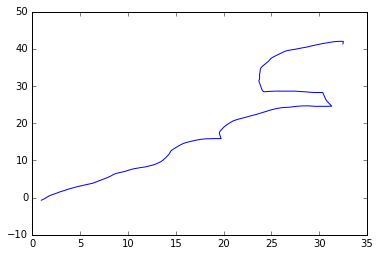

In [246]:
alpha = 50  #strength of OU forcing
K = 5  #covariance of weathervane
w = 0  #logistic parameter (default for now)
T = 1000
dt = 0.6  #seconds
v_m = 0.12  #mm/s
v_s = 0.01  #std of speed
time = np.arange(0,T*dt,dt)
xs = np.zeros(time.shape)
ys = np.zeros(time.shape)  #2D location
xs[0] = np.random.randn()
ys[0] = np.random.randn()
ths = np.zeros(time.shape)  #agle with 1,0
ths[0] = np.random.randn()
dxy = np.random.randn(2)

#with turning (Brownian-like tragectories)
for t in range(1,len(time)):
    
    #concentration = gradient(C0,xs[t-1],ys[t-1])
    dC = gradient(C0, xs[t-1],ys[t-1]) - gradient(C0, xs[t-2],ys[t-2])
    dc_perp = dc_measure(dxy,xs[t-1],ys[t-1])      
    dth = d_theta(alpha, -dc_perp, K, 0, dC)
    ths[t] = ths[t-1] + dth*dt
    
    e1 = np.array([1,0])
    vec = np.array([xs[t-1],ys[t-1]])
    theta = math.acos(np.clip(np.dot(vec,e1)/np.linalg.norm(vec)/np.linalg.norm(e1), -1, 1)) #current orienation relative to (1,0)

    vv = v_m + v_s*np.random.randn()
    dd = np.array([vv*np.sin(ths[t]*np.pi/180), vv*np.cos(ths[t]*np.pi/180)])  #displacement
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,s), (-s, c)))  #rotation matrix, changing coordinates
    dxy = np.dot(R,dd)
    
    xs[t] = xs[t-1] + dxy[0]*dt
    ys[t] = ys[t-1] + dxy[1]*dt

    
#plt.plot(ths)
plt.figure()
plt.plot(xs,ys)

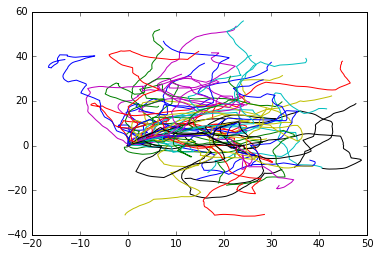

In [247]:
all_dc_p = []
all_dc = []
all_th = []
for ii in range(50):
    xs = np.zeros(time.shape)
    ys = np.zeros(time.shape)  #2D location
    xs[0] = np.random.randn()*0.1
    ys[0] = np.random.randn()*0.1
    ths = np.zeros(time.shape)  #agle with 1,0
    ths[0] = np.random.rand()*0
    dcs = np.zeros(time.shape)
    dcps = np.zeros(time.shape)
    dths = np.zeros(time.shape)
    for t in range(1,len(time)):
        
        dC = gradient(C0, xs[t-1],ys[t-1]) - gradient(C0, xs[t-2],ys[t-2])
        dc_perp = dc_measure(dxy,xs[t-1],ys[t-1])      
        dth = d_theta(alpha, -dc_perp, K, 0, dC)
        ths[t] = ths[t-1] + dth*dt
        
        dcs[t] = dC
        dcps[t] = dc_perp
        dths[t] = dth
        
        
        e1 = np.array([1,0])
        vec = np.array([xs[t-1],ys[t-1]])
        theta = math.acos(np.clip(np.dot(vec,e1)/np.linalg.norm(vec)/np.linalg.norm(e1), -1, 1)) #current orienation relative to (1,0)

        vv = v_m + v_s*np.random.randn()
        dd = np.array([vv*np.sin(ths[t]*np.pi/180), vv*np.cos(ths[t]*np.pi/180)])  #displacement
        c, s = np.cos(theta), np.sin(theta)
        R = np.array(((c,s), (-s, c)))  #rotation matrix, changing coordinates
        dxy = np.dot(R,dd)

        xs[t] = xs[t-1] + dxy[0]*dt
        ys[t] = ys[t-1] + dxy[1]*dt
        
    all_dc_p.append(dcps)  #recording dC_perpendicular
    all_dc.append(dcs)  #recording dC
    all_th.append(dths)  #recording head angle
        
    plt.plot(xs,ys)
    plt.hold(True)

In [248]:
#data array prep
data_th = np.array(all_th).reshape(-1)
data_dcp = np.array(all_dc_p).reshape(-1)
data_dc = np.array(all_dc).reshape(-1)

In [249]:
np.array(all_th).shape

(50, 1000)

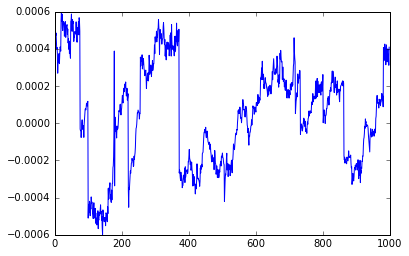

In [250]:
plt.plot(np.array(all_dc)[1,:].T);

In [251]:
bb = 30
xes = np.linspace(min(data_dc),max(data_dc), bb)
yes = np.linspace(min(data_dcp),max(data_th), bb)

In [252]:
H,xe,ye = np.histogram2d(data_dc,data_th,bins = (xes,yes))

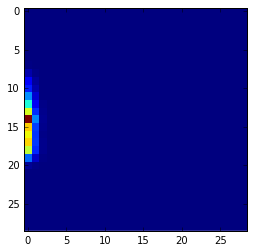

In [253]:
plt.imshow(H,interpolation='None')

In [254]:
#Compute probability(batch,base) and mutual information
Pjoint = (H+10**-10)/np.sum(H)
Pc = np.sum(Pjoint,axis=0)
Pt = np.sum(Pjoint,axis=1)
info = np.zeros(Pjoint.shape)
for ii in range(0,info.shape[0]):
    for jj in range(0,info.shape[1]):
        info[ii,jj] = Pjoint[ii,jj]*np.log2(Pjoint[ii,jj]/(Pc[ii]*Pt[jj]))
np.nansum(info)  #mutual information I(batch,base)

49.16473766442352

## Entropic tasks

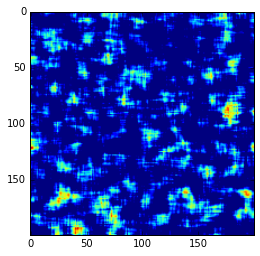

In [307]:
randtemp = np.random.randn(200,200)
from scipy import signal
smoothK = np.ones((10,10))
grad = signal.convolve2d(randtemp, smoothK, boundary='symm', mode='same')
ent_env = grad/np.max(grad)

ent_env[ent_env<0] = 0
plt.imshow(ent_env)

In [308]:
def dc_measure2(Camp, dxy,xx,yy):
    perp_dir = np.array([-dxy[1], dxy[0]])
    perp_dir = perp_dir/np.linalg.norm(perp_dir)
    perp_dC = ent_env[round(int(xx+perp_dir[0])), round(int(yy+perp_dir[1]))] - ent_env[round(int(xx-perp_dir[0])), round(int(yy-perp_dir[1]))]
    return Camp*perp_dC

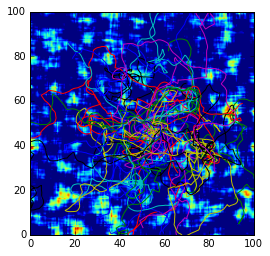

In [335]:
all_dc_p2 = []  #recording dC_perpendicular
all_dc2 = []  #recording dC
all_th2 = []
    
Camp = 0.2
alpha = 50  #strength of OU forcing
K = 5  #covariance of weathervane
w = 0  #logistic parameter (default for now)
T = 3000
dt = 0.6  #seconds
v_m = 0.12  #mm/s
v_s = 0.01  #std of speed
time = np.arange(0,T*dt,dt)

rep = 30
accum = np.zeros(rep)

for tr in range(rep):
    xs = np.zeros(time.shape)
    ys = np.zeros(time.shape)  #2D location
    xs[0] = 50  #middle of the environment
    ys[0] = 50
    ths = np.zeros(time.shape)  #agle with 1,0
    ths[0] = np.random.randn()
    dxy = np.random.randn(2)
    dcs = np.zeros(time.shape)
    dcps = np.zeros(time.shape)
    dths = np.zeros(time.shape)
    for t in range(1,len(time)):
        
        accum[tr] = accum[tr] + ent_env[round(int(xs[t-1])),round(int(ys[t-1]))]
        dC = Camp*(ent_env[round(int(xs[t-1])),round(int(ys[t-1]))] - ent_env[round(int(xs[t-2])),round(int(ys[t-2]))])
        dc_perp = dc_measure2(Camp, dxy,xs[t-1],ys[t-1])      
        dth = d_theta(alpha, -dc_perp, K, 0, dC)
        ths[t] = ths[t-1] + dth*dt

        e1 = np.array([1,0])
        vec = np.array([xs[t-1],ys[t-1]])
        theta = math.acos(np.clip(np.dot(vec,e1)/np.linalg.norm(vec)/np.linalg.norm(e1), -1, 1)) #current orienation relative to (1,0)

        vv = v_m + v_s*np.random.randn()
        dd = np.array([vv*np.sin(ths[t]*np.pi/180), vv*np.cos(ths[t]*np.pi/180)])  #displacement
        c, s = np.cos(theta), np.sin(theta)
        R = np.array(((c,s), (-s, c)))  #rotation matrix, changing coordinates
        dxy = np.dot(R,dd)

        xs[t] = xs[t-1] + dxy[0]*dt
        ys[t] = ys[t-1] + dxy[1]*dt
        
        dcs[t] = dC
        dcps[t] = dc_perp
        dths[t] = dth
        
    all_dc_p2.append(dcps)  #recording dC_perpendicular
    all_dc2.append(dcs)  #recording dC
    all_th2.append(dths)  #recording head angle

    plt.plot(xs,ys)
    
plt.hold(True)
plt.imshow(ent_env, extent=[0,100,0,100])


In [336]:
data_th2 = np.array(all_th2).reshape(-1)
data_dcp2 = np.array(all_dc_p2).reshape(-1)
data_dc2 = np.array(all_dc2).reshape(-1)

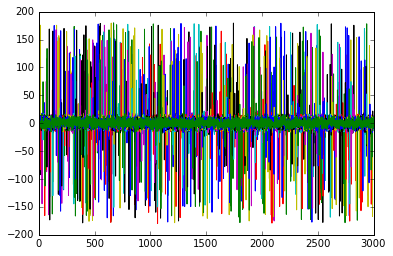

In [337]:
plt.plot(np.array(all_th2).T);

In [338]:
bb = 30
xes = np.linspace(min(data_dc2),max(data_dc2), bb)
yes = np.linspace(min(data_th2),max(data_th2), bb)

H = 0
H,xe,ye = np.histogram2d(data_dc2, data_th2, bins = (xes,yes))

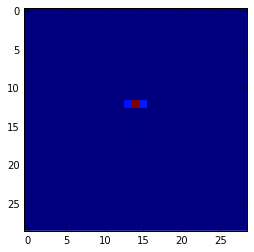

In [345]:
plt.imshow(H,interpolation='None')

In [342]:
H

array([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00,
  

In [343]:
#Compute probability(batch,base) and mutual information
Pjoint = (H+10**-10)/np.sum(H)
Pc = np.sum(Pjoint,axis=0)
Pt = np.sum(Pjoint,axis=1)
info = np.zeros(Pjoint.shape)
for ii in range(0,info.shape[0]):
    for jj in range(0,info.shape[1]):
        info[ii,jj] = Pjoint[ii,jj]*np.log2(Pjoint[ii,jj]/(Pc[ii]*Pt[jj]))
np.nansum(info)  #mutual information I(batch,base)

16.502073785313478